In [78]:
from lsh import *
from utils import *
from query import *

%load_ext autoreload
%autoreload 2

PATH_IMGS     = "imnet-val/val/"
FILE_FEATURES = "imnet-val/cnn-5000.p"
FNAME_OFFSET  = 48 #prefix of stored file names to chop off
IMSIZE        = (224, 224)

data = dataset(FILE_FEATURES,PATH_IMGS,IMSIZE,normalize=True,fname_offt=FNAME_OFFSET)

PATH_IMGS     = "imnet-test-1000/imgs/"
FILE_FEATURES = "imnet-test-1000/cnn-1000.p"
FNAME_OFFSET  = 23 #prefix of stored file names to chop off
IMSIZE        = (224, 224)
queries = dataset(FILE_FEATURES,PATH_IMGS,IMSIZE,normalize=True,fname_offt=FNAME_OFFSET)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


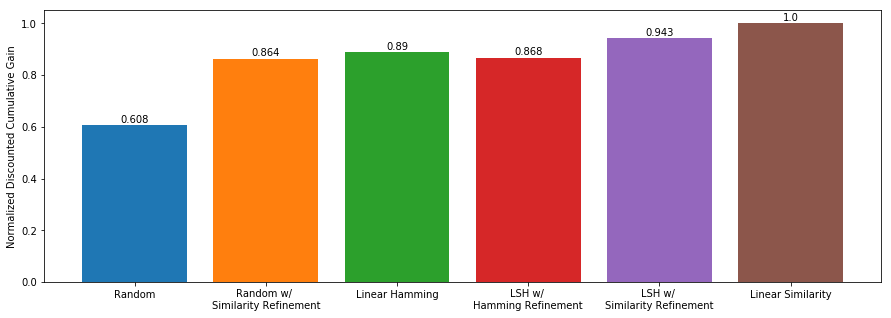

0.0015664005279541016 0.9428705777648518


In [79]:
b = 200 #hash bits
M = 30  #number of permutations

query_obj = query(data=data, queries_dataset=queries, hash_bits=b, 
                  permutations=M)

L = 4   #number of neighbors to make candidates
k = 10  #top-k nearest neighbors
N_queries = 100

t, ndgc = query_obj.time_and_compare(N_queries, N_neighbor_candidates=L, k_report=k)
query_obj.ndgc_plot()
print(t, ndgc)

In [80]:
def pareto_frontier(Xs, Ys, maxX = True, maxY = True):
    myList = sorted([[Xs[i], Ys[i]] for i in range(len(Xs))], reverse=maxX)
    p_front = [myList[0]]    
    for pair in myList[1:]:
        if maxY: 
            if pair[1] >= p_front[-1][1]:
                p_front.append(pair)
        else:
            if pair[1] <= p_front[-1][1]:
                p_front.append(pair)
    p_frontX = [pair[0] for pair in p_front]
    p_frontY = [pair[1] for pair in p_front]
    return p_frontX, p_frontY

In [81]:
k = 10  #top-k nearest neighbors
N_queries = 200


Ls = [4] #number of neighbors to make candidates
bs = [200] #hash bits
es = [2.7] #error tolerance

# Ls = [0, 2, 4, 8] #number of neighbors to make candidates
# bs = [20, 80, 200, 600] #hash bits
es = [4, 2.7, 2.1, 1.5] #error tolerance
Ms = []
N_data = data.X.shape[1]
for e in es:
    Ms.append(round(2*N_data**(1/(1+e))))

ts = np.zeros((len(bs), len(es), len(Ls)))
ndgcs = np.zeros((len(bs), len(es), len(Ls)))
print("N_data, N_queries, {}, {}".format(N_data, N_queries))
print("Ls,", Ls)
print("bs,", bs)
print("es,", es)
print("Ms,", Ms)
print("{:>6}, {:>6}, {:>6}, {:>5}, {:>5}, {:>5}, {:>5}, {:>8}, {:>8}".format(
    "b_idx", "e_idx", "L_idx", "b", "eps", "M", "L", "t (msec)", "ndgc"))
for b_idx,b in enumerate(bs):
    for e_idx,e in enumerate(es):
        t1 = time.time()
        query_obj = query(data=data, queries_dataset=queries, hash_bits=b, 
                          permutations=Ms[e_idx])
        print("precomp", time.time() - t1)
        
        for L_idx,L in enumerate(Ls):
            t1 = time.time()
            t, ndgc = query_obj.time_and_compare(N_queries, N_neighbor_candidates=L, k_report=k)
            ts[b_idx,e_idx,L_idx] = t
            ndgcs[b_idx,e_idx,L_idx] = ndgc
            print("{:6d}, {:6d}, {:6d}, {:5d}, {:5.1f}, {:5d}, {:5d}, {:8.3f}, {:8.3f}".format(
                b_idx, e_idx, L_idx, b, e, M, L, t*1000, ndgc))
            print("query", time.time() - t1, (time.time() - t1)/N_queries)



N_data, N_queries, 5000, 200
Ls, [4]
bs, [200]
es, [4, 2.7, 2.1, 1.5]
Ms, [11, 20, 31, 60]
 b_idx,  e_idx,  L_idx,     b,   eps,     M,     L, t (msec),     ndgc
precomp 0.14363527297973633
     0,      0,      0,   200,   4.0,    30,     4,    0.696,    0.896
query 3.5359230041503906
precomp 0.22188091278076172
     0,      1,      0,   200,   2.7,    30,     4,    1.070,    0.927
query 3.978057861328125
precomp 0.30315494537353516
     0,      2,      0,   200,   2.1,    30,     4,    1.651,    0.945
query 3.984088897705078
precomp 0.5537359714508057
     0,      3,      0,   200,   1.5,    30,     4,    3.142,    0.971
query 4.955265045166016


---

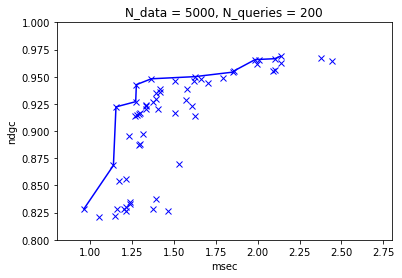

In [70]:
axlims = [.8, 2.8, 0.8, 1]

optX, optY = pareto_frontier(ts.flatten()*1000, ndgcs.flatten(), maxX = False)
plt.plot(optX, optY, '-b')

plt.plot(ts.flatten()*1000, ndgcs.flatten(), 'xb')
plt.xlabel('msec')
plt.ylabel('ndgc')
plt.title('N_data = {}, N_queries = {}'.format(N_data, N_queries))
plt.axis(axlims)
plt.show()


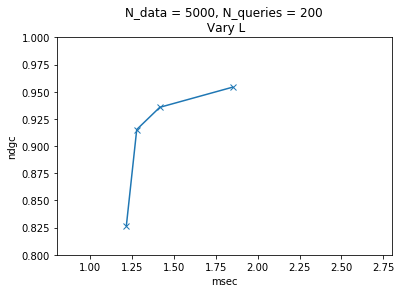

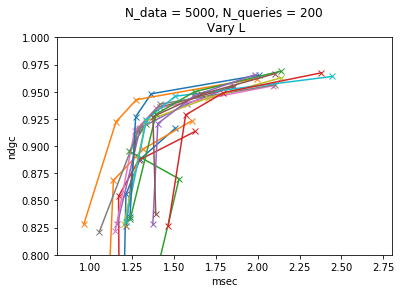

In [71]:
plt.plot(ts[1, 1,:]*1000, ndgcs[1, 1,:], 'x-')
plt.xlabel('msec')
plt.ylabel('ndgc')
plt.title('N_data = {}, N_queries = {}\n Vary L'.format(N_data, N_queries))
plt.axis(axlims)
plt.show()

for b_idx, b in enumerate(bs):
    for e_idx, e in enumerate(es):
        plt.plot(ts[b_idx, e_idx, :]*1000, ndgcs[b_idx, e_idx, :], 'x-')
        
plt.xlabel('msec')
plt.ylabel('ndgc')
plt.title('N_data = {}, N_queries = {}\n Vary L'.format(N_data, N_queries))
plt.axis(axlims)
plt.show()

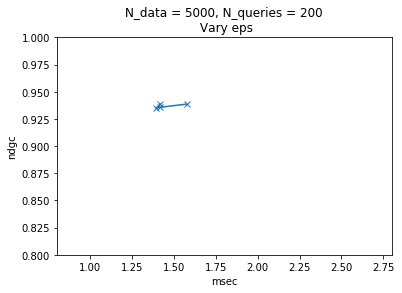

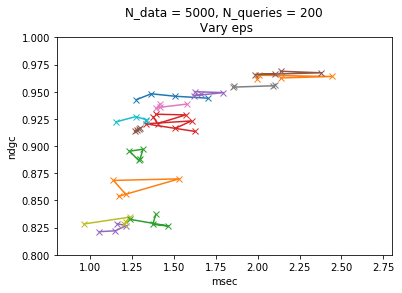

In [75]:
plt.plot(ts[1, :, 2]*1000, ndgcs[1, :, 2], 'x-')
plt.xlabel('msec')
plt.ylabel('ndgc')
plt.title('N_data = {}, N_queries = {}\n Vary eps'.format(N_data, N_queries))
plt.axis(axlims)
plt.show()

for b_idx, b in enumerate(bs):
    for L_idx, L in enumerate(Ls):
        plt.plot(ts[b_idx, :, L_idx]*1000, ndgcs[b_idx, :, L_idx], 'x-')
        
plt.xlabel('msec')
plt.ylabel('ndgc')
plt.title('N_data = {}, N_queries = {}\n Vary eps'.format(N_data, N_queries))
plt.axis(axlims)
plt.show()

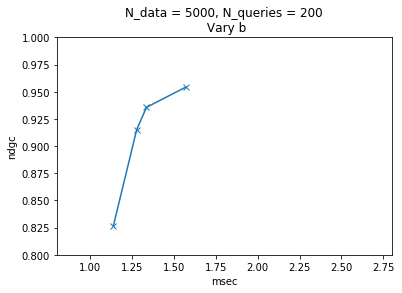

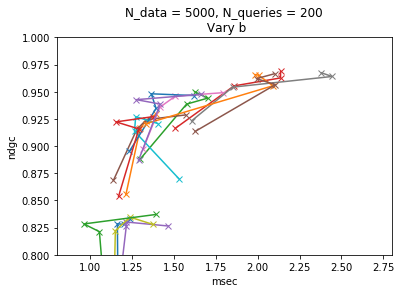

In [73]:
plt.plot(ts[:, 1,1]*1000, ndgcs[1, 1,:], 'x-')
plt.xlabel('msec')
plt.ylabel('ndgc')
plt.title('N_data = {}, N_queries = {}\n Vary b'.format(N_data, N_queries))
plt.axis(axlims)
plt.show()

for e_idx, e in enumerate(es):
    for L_idx, L in enumerate(Ls):
        plt.plot(ts[:, e_idx, L_idx]*1000, ndgcs[:, e_idx, L_idx], 'x-')
        
plt.xlabel('msec')
plt.ylabel('ndgc')
plt.title('N_data = {}, N_queries = {}\n Vary b'.format(N_data, N_queries))
plt.axis(axlims)
plt.show()